In [1]:
import os # For operating system dependent functionality
import cv2 # OpenCV array structures are converted to and from Numpy arrays - For reading Images
import glob # Find all the pathnames matching a specified pattern
import numpy as np # A powerful N-dimensional array object
import pandas as pd # Data frame manipulation
from matplotlib import pyplot as plt # Plotting graphs
import seaborn as sns # Plotting graphs
from keras.utils import np_utils # Modelling
from sklearn.metrics import accuracy_score, classification_report # Modelling
from PIL import Image 

C:\Users\HARSHIT\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
from keras.models import Sequential 
from keras.layers import Convolution2D 
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers.core import Activation, Dropout

In [6]:
import scipy.io
mat = scipy.io.loadmat('E:/Text recog/train/digitStruct.mat')

NotImplementedError: Please use HDF reader for matlab v7.3 files

In [7]:
import h5py 
f= h5py.File('E:/Text recog/train/digitStruct.mat','r')

In [8]:
items = f.items()
keys = f.keys()

In [9]:
list(f.keys())
list(f['digitStruct'].keys())
f['digitStruct'].attrs['name']

KeyError: "Can't open attribute (can't locate attribute: 'name')"

In [10]:
data = f['digitStruct']
names = list(data['name'])
print(data.name)
#print(names.name)
print(type(data))
print(type(names))
names[0]

#Checkout what keys are inside that group.
for key in data.keys():
    print(key)

names = data['name']
names[0][0]
v = data[names[0][0]].value
for asc in v:
    print(chr(asc))
#print(names[0])
#Do whatever you want with data

#After you are done
#data.close()

/digitStruct
<class 'h5py._hl.group.Group'>
<class 'list'>
bbox
name
1
.
p
n
g


In [11]:
def get_box_data(index, f):
    """
    get `left, top, width, height` of each picture
    :param index:
    :param hdf5_data:
    :return:
    """
    meta_data = dict()
    meta_data['height'] = []
    meta_data['label'] = []
    meta_data['left'] = []
    meta_data['top'] = []
    meta_data['width'] = []

    def print_attrs(name, obj):
        vals = []
        if obj.shape[0] == 1:
            vals.append(int(obj[0][0]))
        else:
            for k in range(obj.shape[0]):
                vals.append(int(f[obj[k][0]][0][0]))
        meta_data[name] = vals

    box = f['/digitStruct/bbox'][index]
    f[box[0]].visititems(print_attrs)
    return meta_data

def get_name(index, f):
    name = f['/digitStruct/name']
    return ''.join([chr(v[0]) for v in f[name[index][0]].value])

In [12]:
folder = 'E:/Text recog/train'
import tqdm

In [13]:
mat_data = h5py.File(os.path.join(folder, 'digitStruct.mat'))
size = mat_data['/digitStruct/name'].size

for _i in tqdm.tqdm(range(size)):
    pic = get_name(_i, mat_data)
    box = get_box_data(_i, mat_data)

100%|██████████| 33402/33402 [04:27<00:00, 125.09it/s]


In [11]:
print(get_name(156,f))
get_box_data(156,f)

157.png


{'height': [37, 37],
 'label': [5, 7],
 'left': [37, 65],
 'top': [7, 7],
 'width': [26, 23]}

In [321]:
print(get_name(3099,f))
print(get_box_data(3099,f))

3100.png
{'height': [38, 38, 38], 'label': [1, 2, 6], 'left': [-1, 4, 22], 'top': [12, 12, 13], 'width': [3, 18, 17]}


In [14]:
#IMporting training dataset 

PATH = r'E:/Text recog/train/*.png'
files = glob.glob(PATH)
X_train = [ None for i in range(len(files))]
print(len(files))
for fl in tqdm.tqdm(files):
    flbase = os.path.basename(fl)
    idx = int(flbase[:-4])-1
    img = cv2.imread(fl, 0)
    #X_train.append(img)
    #X_name.append(flbase)
    X_train[idx] = img

33402


100%|██████████| 33402/33402 [04:45<00:00, 116.84it/s]


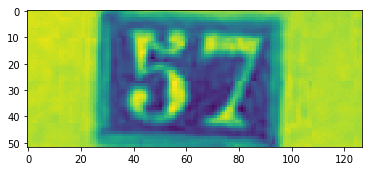

In [15]:
plt.imshow(X_train[156])

100%|██████████| 8350/8350 [09:49<00:00, 15.45it/s]


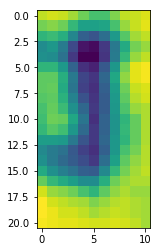

"\ni = 156\nx = get_box_data(i,f)['left'][0]\ny = get_box_data(i,f)['top'][0]\nw = get_box_data(i,f)['width'][0]\nh = get_box_data(i,f)['height'][0]\ncrop = X_train[i][y:y+h, x:x+w]\nimgplot = plt.imshow(crop)\nplt.show()\n"

In [16]:
#cropping images
crop_imgs = []
crop_imgs_label =[]
for i in tqdm.tqdm(range(int(len(files)/4))):
    for j in range(len(get_box_data(i,f)['height'])):
        x = get_box_data(i,f)['left'][j]
        y = get_box_data(i,f)['top'][j]
        w = get_box_data(i,f)['width'][j]
        h = get_box_data(i,f)['height'][j]

        crop = X_train[i][y:y+h, x:x+w]
        crop_imgs.append(crop) 
        crop_imgs_label.append(get_box_data(i,f)['label'][j])
       

plt.imshow(crop_imgs[11])
plt.show()
'''
i = 156
x = get_box_data(i,f)['left'][0]
y = get_box_data(i,f)['top'][0]
w = get_box_data(i,f)['width'][0]
h = get_box_data(i,f)['height'][0]
crop = X_train[i][y:y+h, x:x+w]
imgplot = plt.imshow(crop)
plt.show()
'''
#crop_img = img[y:y+h, x:x+w]
#cv2.imshow("cropped", crop_img)
#cv2.waitKey(0)

In [17]:
filenames = []
for i in (range(int(len(files)/4))):
    for j in range(len(get_box_data(i,f)['height'])):
        filenames.append(i)
        

In [19]:
#Counter


print(filenames[6875])
print(crop_imgs_label[1571])


3099
2


In [20]:
print(crop_imgs[1571].shape)


(108, 0)


33.93898323535815

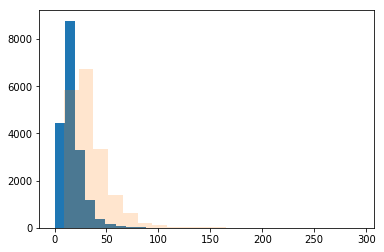

In [21]:
# Checking the width distribution of images


heights = []
width = []
for i in range(len(crop_imgs)):
    x= crop_imgs[i].shape[1]
    heights.append(x)
    z= crop_imgs[i].shape[0]
    width.append(z)
plt.hist(heights,bins=20)
plt.hist(width,bins=20, alpha = 0.2)
np.mean(width)

In [300]:
# Making the images into squares for feeding in the CNN

from PIL import Image
sqr_img = []
for i in range(len(crop_imgs)):
    
    im = crop_imgs[i]
    if im.shape[0] >= im.shape[1] :
        sqrWidth = im.shape[0]
    else :
        sqrWidth = im.shape[1]
    assert(sqrWidth>0)
    #assert(np.size(im)>0)
    if(np.size(im)==0):
        print(i,im.shape)
        continue
    im_resize = cv2.resize(im, (sqrWidth, sqrWidth),interpolation = cv2.INTER_CUBIC )
    sqr_img.append(im_resize)

543 (30, 0)
1571 (108, 0)
6875 (38, 0)
11710 (40, 0)
15150 (69, 0)


In [322]:
#Making all images to 36*36

sqr_img_small = []

for i in range(len(sqr_img)):
    
    im2 = sqr_img[i]
    
    im_resize2 = cv2.resize(im2, (36, 36),interpolation = cv2.INTER_CUBIC )
    sqr_img_small.append(im_resize2)

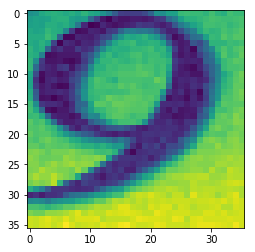

(36, 36)
9


In [323]:
#Verifying labels vs images (squared)
i=1

plt.imshow(sqr_img_small[i])
plt.show()
print(sqr_img_small[i].shape)
print(crop_imgs_label[i])

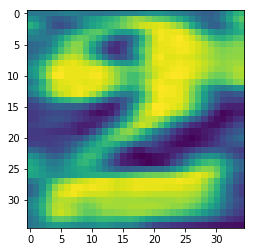

2


In [19]:
#Verifying labels vs images (squared)

i=86

plt.imshow(sqr_img[i])
plt.show()
im_resize.shape
print(crop_imgs_label[i])

In [178]:
print(sqr_img[6].shape)
print(np.asarray(sqr_img).shape)

(34, 34)
(220,)


In [351]:
#Resizing to 219*219

sqr_pad = []
for i in range(len(sqr_img)):
    width = int((219- (sqr_img[i].shape[1]))/2)
    if (2*width)+ sqr_img[i].shape[1] == 219 :
        
        image = cv2.copyMakeBorder( sqr_img[i], width , width , width , width , cv2.BORDER_)
     
    else :
        image = cv2.copyMakeBorder( sqr_img[i], width+1 , width , width+1 , width , cv2.BORDER_CONSTANT)  
    sqr_pad.append(image)

error: OpenCV(3.4.4) C:\projects\opencv-python\opencv\modules\core\src\copy.cpp:1186: error: (-215:Assertion failed) top >= 0 && bottom >= 0 && left >= 0 && right >= 0 && _src.dims() <= 2 in function 'cv::copyMakeBorder'


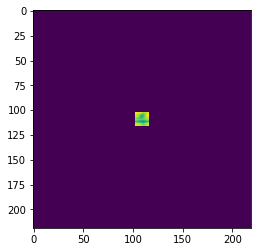

(219, 219)


4

In [202]:
i=15

plt.imshow(sqr_pad[i])
plt.show()
print(sqr_pad[i].shape)
crop_imgs_label[i]

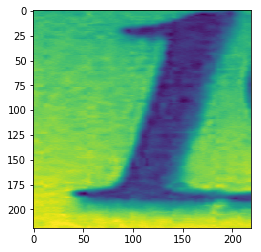

1


In [113]:
#Verifying labels vs images (squared)

i=0

plt.imshow(sqr_img_resize[i])
plt.show()
im_resize.shape
print(crop_imgs_label[i])

In [324]:
#Model Creation 


X_training = sqr_img_small
X_training = np.array(X_training)
print(type(X_training))
print(X_training[1])
#X_training /= 255


<class 'numpy.ndarray'>
[[ 65  67  74 ...  82  80  80]
 [ 70  72  71 ...  81  82  83]
 [ 71  72  71 ...  79  81  83]
 ...
 [ 91  89  89 ... 100 101 102]
 [101 100 102 ... 103 102 102]
 [101 100 102 ... 102 106 102]]


In [325]:
X_training = X_training.reshape(X_training.shape[0], 36, 36,1)

In [326]:
X_training.shape

(18367, 36, 36, 1)

In [328]:
crop_imgs_label.pop(543)
crop_imgs_label.pop(1571)
crop_imgs_label.pop(6875)
crop_imgs_label.pop(11710)
crop_imgs_label.pop(15150)

3

In [329]:
len(crop_imgs_label)

18367

In [ ]:
543 (30, 0)
1571 (108, 0)
6875 (38, 0)
11710 (40, 0)
15150

In [330]:

# Categorising into classes 

crop_imgs_lab = np_utils.to_categorical(np.asarray(crop_imgs_label)-1)

In [331]:
print(np.unique(crop_imgs_label))
print(crop_imgs_lab.shape)

[ 1  2  3  4  5  6  7  8  9 10]
(18367, 10)


In [332]:
# Training model


model = Sequential()
model.add(Convolution2D(filters = 6,kernel_size =(2,2),strides = (2,2),input_shape=(36, 36,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Convolution2D(filters = 6 ,kernel_size =(2,2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Convolution2D(filters = 12, kernel_size =(2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(36))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))

In [343]:
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
# Fit the model
model.fit(X_training, crop_imgs_lab,validation_split=0.1, epochs=50, batch_size=200)

Train on 16530 samples, validate on 1837 samples
Epoch 1/50
16530/16530 [==============================] - ETA: 27:24 - loss: 1.4976 - acc: 0.49 - ETA: 8:56 - loss: 1.5222 - acc: 0.4750 - ETA: 6:38 - loss: 1.5177 - acc: 0.481 - ETA: 4:19 - loss: 1.4676 - acc: 0.493 - ETA: 3:10 - loss: 1.4708 - acc: 0.505 - ETA: 2:28 - loss: 1.4602 - acc: 0.510 - ETA: 2:00 - loss: 1.4614 - acc: 0.509 - ETA: 1:50 - loss: 1.4678 - acc: 0.505 - ETA: 1:33 - loss: 1.4518 - acc: 0.506 - ETA: 1:19 - loss: 1.4576 - acc: 0.504 - ETA: 1:09 - loss: 1.4476 - acc: 0.509 - ETA: 1:01 - loss: 1.4368 - acc: 0.512 - ETA: 54s - loss: 1.4377 - acc: 0.511 - ETA: 51s - loss: 1.4365 - acc: 0.51 - ETA: 45s - loss: 1.4449 - acc: 0.51 - ETA: 41s - loss: 1.4384 - acc: 0.51 - ETA: 37s - loss: 1.4249 - acc: 0.51 - ETA: 33s - loss: 1.4200 - acc: 0.51 - ETA: 30s - loss: 1.4153 - acc: 0.52 - ETA: 27s - loss: 1.4216 - acc: 0.52 - ETA: 25s - loss: 1.4199 - acc: 0.52 - ETA: 22s - loss: 1.4211 - acc: 0.52 - ETA: 20s - loss: 1.4207 - acc: 

16530/16530 [==============================] - ETA: 1s - loss: 1.6692 - acc: 0.485 - ETA: 2s - loss: 1.4962 - acc: 0.505 - ETA: 2s - loss: 1.4602 - acc: 0.504 - ETA: 1s - loss: 1.4495 - acc: 0.511 - ETA: 1s - loss: 1.4255 - acc: 0.523 - ETA: 1s - loss: 1.4156 - acc: 0.524 - ETA: 2s - loss: 1.4192 - acc: 0.525 - ETA: 1s - loss: 1.4129 - acc: 0.526 - ETA: 1s - loss: 1.4081 - acc: 0.529 - ETA: 1s - loss: 1.4019 - acc: 0.533 - ETA: 1s - loss: 1.4065 - acc: 0.533 - ETA: 1s - loss: 1.4174 - acc: 0.530 - ETA: 1s - loss: 1.4119 - acc: 0.530 - ETA: 1s - loss: 1.4060 - acc: 0.532 - ETA: 1s - loss: 1.4019 - acc: 0.533 - ETA: 1s - loss: 1.4002 - acc: 0.534 - ETA: 1s - loss: 1.4001 - acc: 0.534 - ETA: 1s - loss: 1.4020 - acc: 0.534 - ETA: 1s - loss: 1.4034 - acc: 0.532 - ETA: 1s - loss: 1.4165 - acc: 0.527 - ETA: 0s - loss: 1.4156 - acc: 0.527 - ETA: 0s - loss: 1.4185 - acc: 0.525 - ETA: 0s - loss: 1.4161 - acc: 0.525 - ETA: 0s - loss: 1.4200 - acc: 0.525 - ETA: 0s - loss: 1.4124 - acc: 0.527 - ETA

16530/16530 [==============================] - ETA: 1s - loss: 1.4589 - acc: 0.495 - ETA: 1s - loss: 1.4180 - acc: 0.530 - ETA: 1s - loss: 1.4228 - acc: 0.524 - ETA: 1s - loss: 1.4081 - acc: 0.533 - ETA: 1s - loss: 1.4046 - acc: 0.529 - ETA: 1s - loss: 1.3914 - acc: 0.530 - ETA: 1s - loss: 1.3849 - acc: 0.531 - ETA: 1s - loss: 1.3860 - acc: 0.533 - ETA: 1s - loss: 1.3792 - acc: 0.534 - ETA: 1s - loss: 1.3837 - acc: 0.534 - ETA: 1s - loss: 1.3860 - acc: 0.532 - ETA: 1s - loss: 1.3930 - acc: 0.530 - ETA: 1s - loss: 1.3956 - acc: 0.531 - ETA: 1s - loss: 1.3938 - acc: 0.530 - ETA: 1s - loss: 1.3969 - acc: 0.529 - ETA: 1s - loss: 1.3998 - acc: 0.528 - ETA: 1s - loss: 1.4025 - acc: 0.528 - ETA: 1s - loss: 1.4021 - acc: 0.528 - ETA: 0s - loss: 1.4028 - acc: 0.528 - ETA: 0s - loss: 1.4028 - acc: 0.527 - ETA: 0s - loss: 1.4040 - acc: 0.528 - ETA: 0s - loss: 1.4039 - acc: 0.529 - ETA: 0s - loss: 1.4066 - acc: 0.528 - ETA: 0s - loss: 1.4063 - acc: 0.528 - ETA: 0s - loss: 1.4007 - acc: 0.530 - ETA

16530/16530 [==============================] - ETA: 2s - loss: 1.3252 - acc: 0.560 - ETA: 2s - loss: 1.3930 - acc: 0.546 - ETA: 2s - loss: 1.3856 - acc: 0.547 - ETA: 2s - loss: 1.3916 - acc: 0.545 - ETA: 2s - loss: 1.3929 - acc: 0.542 - ETA: 1s - loss: 1.3876 - acc: 0.541 - ETA: 1s - loss: 1.3859 - acc: 0.541 - ETA: 1s - loss: 1.3977 - acc: 0.538 - ETA: 1s - loss: 1.3960 - acc: 0.537 - ETA: 1s - loss: 1.4002 - acc: 0.539 - ETA: 1s - loss: 1.3916 - acc: 0.541 - ETA: 1s - loss: 1.4022 - acc: 0.538 - ETA: 1s - loss: 1.4006 - acc: 0.536 - ETA: 1s - loss: 1.3966 - acc: 0.535 - ETA: 1s - loss: 1.3912 - acc: 0.536 - ETA: 1s - loss: 1.3931 - acc: 0.538 - ETA: 1s - loss: 1.3959 - acc: 0.538 - ETA: 1s - loss: 1.3910 - acc: 0.538 - ETA: 1s - loss: 1.3873 - acc: 0.541 - ETA: 1s - loss: 1.3887 - acc: 0.541 - ETA: 1s - loss: 1.3863 - acc: 0.541 - ETA: 1s - loss: 1.3809 - acc: 0.543 - ETA: 0s - loss: 1.3843 - acc: 0.545 - ETA: 0s - loss: 1.3835 - acc: 0.545 - ETA: 0s - loss: 1.3840 - acc: 0.544 - ETA

16530/16530 [==============================] - ETA: 1s - loss: 1.5698 - acc: 0.450 - ETA: 2s - loss: 1.4493 - acc: 0.508 - ETA: 2s - loss: 1.3943 - acc: 0.519 - ETA: 2s - loss: 1.3698 - acc: 0.521 - ETA: 2s - loss: 1.3405 - acc: 0.528 - ETA: 2s - loss: 1.3554 - acc: 0.533 - ETA: 2s - loss: 1.3679 - acc: 0.528 - ETA: 2s - loss: 1.3627 - acc: 0.536 - ETA: 1s - loss: 1.3579 - acc: 0.536 - ETA: 1s - loss: 1.3643 - acc: 0.537 - ETA: 1s - loss: 1.3633 - acc: 0.540 - ETA: 1s - loss: 1.3690 - acc: 0.539 - ETA: 1s - loss: 1.3684 - acc: 0.541 - ETA: 1s - loss: 1.3670 - acc: 0.541 - ETA: 1s - loss: 1.3665 - acc: 0.541 - ETA: 1s - loss: 1.3653 - acc: 0.542 - ETA: 1s - loss: 1.3597 - acc: 0.546 - ETA: 1s - loss: 1.3564 - acc: 0.547 - ETA: 1s - loss: 1.3656 - acc: 0.543 - ETA: 1s - loss: 1.3648 - acc: 0.543 - ETA: 1s - loss: 1.3664 - acc: 0.543 - ETA: 1s - loss: 1.3647 - acc: 0.544 - ETA: 1s - loss: 1.3635 - acc: 0.543 - ETA: 1s - loss: 1.3633 - acc: 0.543 - ETA: 0s - loss: 1.3655 - acc: 0.542 - ETA

Epoch 44/50
16530/16530 [==============================] - ETA: 2s - loss: 1.4207 - acc: 0.545 - ETA: 2s - loss: 1.3750 - acc: 0.556 - ETA: 2s - loss: 1.3792 - acc: 0.564 - ETA: 2s - loss: 1.4009 - acc: 0.559 - ETA: 2s - loss: 1.3771 - acc: 0.562 - ETA: 1s - loss: 1.3682 - acc: 0.565 - ETA: 1s - loss: 1.3741 - acc: 0.561 - ETA: 1s - loss: 1.3641 - acc: 0.562 - ETA: 1s - loss: 1.3668 - acc: 0.560 - ETA: 1s - loss: 1.3572 - acc: 0.563 - ETA: 1s - loss: 1.3562 - acc: 0.563 - ETA: 1s - loss: 1.3640 - acc: 0.560 - ETA: 1s - loss: 1.3690 - acc: 0.558 - ETA: 1s - loss: 1.3691 - acc: 0.556 - ETA: 1s - loss: 1.3655 - acc: 0.555 - ETA: 1s - loss: 1.3651 - acc: 0.557 - ETA: 1s - loss: 1.3605 - acc: 0.559 - ETA: 1s - loss: 1.3569 - acc: 0.560 - ETA: 1s - loss: 1.3559 - acc: 0.559 - ETA: 1s - loss: 1.3530 - acc: 0.561 - ETA: 1s - loss: 1.3556 - acc: 0.559 - ETA: 1s - loss: 1.3576 - acc: 0.560 - ETA: 0s - loss: 1.3573 - acc: 0.558 - ETA: 0s - loss: 1.3595 - acc: 0.557 - ETA: 0s - loss: 1.3557 - acc:

In [347]:
pred = model.predict(X_training[:15])

# Class prediction
pred_class = model.predict_classes(X_training[:10])
print(pred_class[:10])

[0 8 8 4 0 4 9 4 2 0]


In [25]:
f2= h5py.File('E:/Text recog/test/digitStruct.mat','r')

In [22]:
# Importing TestDAtaset



PATH2 = r'E:/Text recog/test/*.png'
files2 = glob.glob(PATH2)
X_train2 = [ None for i in range(len(files2))]
print(len(files))
for fl2 in files2 :
    flbase2 = os.path.basename(fl2)
    idx2 = int(flbase2[:-4])-1
    img2 = cv2.imread(fl2, 0)
    #X_train.append(img)
    #X_name.append(flbase)
    X_train2[idx2] = img2

33402


In [23]:
# Function to import box data for test

def get_box_data_test(index, f2):
    """
    get `left, top, width, height` of each picture
    :param index:
    :param hdf5_data:
    :return:
    """
    meta_data = dict()
    meta_data['height'] = []
    meta_data['label'] = []
    meta_data['left'] = []
    meta_data['top'] = []
    meta_data['width'] = []

    def print_attrs_test(name, obj):
        vals = []
        if obj.shape[0] == 1:
            vals.append(int(obj[0][0]))
        else:
            for k in range(obj.shape[0]):
                vals.append(int(f2[obj[k][0]][0][0]))
        meta_data[name] = vals

    box = f2['/digitStruct/bbox'][index]
    f2[box[0]].visititems(print_attrs_test)
    return meta_data

#def get_name_test(index, f2):
 #   name = f2['/digitStruct/name']
  #  return ''.join([chr(v[0]) for v in f2[name[index][0]].value])

In [27]:
get_box_data_test(2,f2)

{'height': [16], 'label': [6], 'left': [61], 'top': [6], 'width': [11]}

In [28]:
#cropping images for test
crop_imgs_test = []

for i in range(int(len(files2)/4)) :
    for j in range(len(get_box_data_test(i,f2)['height'])):
        x = get_box_data_test(i,f2)['left'][j]
        y = get_box_data_test(i,f2)['top'][j]
        w = get_box_data_test(i,f2)['width'][j]
        h = get_box_data_test(i,f2)['height'][j]

        crop_test = X_train2[i][y:y+h, x:x+w]
        crop_imgs_test.append(crop_test) 
        #crop_imgs_label.append(get_box_data(i,f)['label'][j])
       



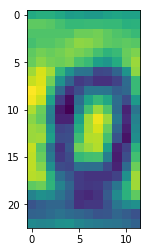

In [372]:
plt.imshow(crop_imgs_test[3])
plt.show()

In [412]:
# Making the test images into squares 


sqr_img_test = []
for i in range(len(crop_imgs_test)):
    
    im_test = crop_imgs_test[i]
    if im_test.shape[0] >= im_test.shape[1] :
        sqrWidth2 = im_test.shape[0]
    else :
        sqrWidth2 = im_test.shape[1]
    assert(sqrWidth2>0)
    #assert(np.size(im)>0)
    if(np.size(im_test)==0):
        print(i,im_test.shape)
        continue
    im_test_resize = cv2.resize(im_test, (sqrWidth2, sqrWidth2),interpolation = cv2.INTER_CUBIC )
    sqr_img_test.append(im_test_resize)

662 (18, 0)
842 (60, 0)
1017 (52, 0)
5186 (71, 0)


In [413]:
#Making all images to 36*36

sqr_img_small_test = []

for i in range(len(sqr_img_test)):
    
    im3 = sqr_img_test[i]
    
    im_resize3 = cv2.resize(im3, (36, 36),interpolation = cv2.INTER_CUBIC )
    sqr_img_small_test.append(im_resize3)

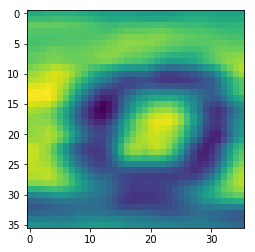

(36, 36)


In [414]:
plt.imshow(sqr_img_small_test[3])
plt.show()
print(sqr_img_small_test[3].shape)

In [415]:
sqr_img_small_test = np.asarray(sqr_img_small_test)

In [416]:
sqr_img_small_test[0].shape

(36, 36)

In [417]:
sqr_img_small_test = sqr_img_small_test.reshape(sqr_img_small_test.shape[0], 36, 36,1)

In [418]:
pred = model.predict(sqr_img_small_test[:20])

# Class prediction
pred_class = model.predict_classes(sqr_img_small_test[:20])
print(pred_class[:20])

[4 2 0 5 5 0 7 0 0 7 4 5 4 0 0 0 0 5 0 3]
